In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from keras.models import Model
%matplotlib inline

In [2]:
from urllib.request import urlretrieve
import zipfile

In [3]:
# Загрузим MovieLens данные. Миллионы данных слишком много для моей машины, поэтому я возьму датасет поменьше
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
# Сдвинем индексы
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [4]:
# Создадим общий датафрейм
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [5]:
# Поделим выборку на тестовую и тренировочную
# 
# Валидационная выборка в моем случаем сопадает с тестовой, т.к. я не планирую перебирать гиперпараметры и буду тренировать
# модель лишь на 4 эпохах
# 
# В общем случае стоило бы сделать 2-ве дополнительных выборки,
# одну для подбора гиперпараметров, а вторую для теста модели уже в конце
train, test = train_test_split(movielens, test_size=0.1, random_state=42)

In [6]:
# Получим константы для компиляции модели, чем больше EMBEDDING_SIZE, тем лучше будет метрика модели,
# на примере я буду обучать при EMBEDDING_SIZE = 10, в общем случае надо брать больше
ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

In [7]:
# Я определяю четырехслойную глубокую нейронную сеть. 
# Внутри модели есть две подмодели — movie_model и user_model
# Я определил модель именно так, чтобы после обучения модели мы могли извлечь эмбеддинги
# После каждого полносвязного слоя применяется функция активации ReLU
# Также в модель были введены Дропауты для уменьшения дисперсии модели
# Метрику буду использовать стандартную для задач регрессии - MSE
# Оптимизатор буду использовать Adam
# Размер для скрытых слоев беру по 80, в общем случае можно увеличивать,
# главное не переобучиться
def MyRecModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,))

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT)(movie_input)
    movie_vec = layers.Flatten()(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,))

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT)(user_input)
    user_vec = layers.Flatten()(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(normalize=True, axes=2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(80, name='FC-1', activation='relu')(merged)
    dropout_1 = layers.Dropout(0.2, name='Dropout-1')(dense_1)

    dense_2 = layers.Dense(80, name='FC-2', activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.2, name='Dropout-2')(dense_2)

    dense_3 = keras.layers.Dense(80, name='FC-3', activation='relu')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

    dense_4 = keras.layers.Dense(80, name='FC-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='output') (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [8]:
# Скомпилируем модель
model, movie_model, user_model = MyRecModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In [9]:
# Для примера я обучаю модель на 4 эпохах, в общем случае надо больше, хотя бы 100
# Хорошо было бы еще добавить warm-up стадию и learning rate scheduler, но результаты и так неплохие
history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                    epochs=4, validation_data = ([test.movie_id, test.user_id],test.rating), 
                    verbose=1)

Epoch 1/4
900/900 [==============================] - 5s 4ms/step - loss: 1.4147 - val_loss: 0.9493
Epoch 2/4
900/900 [==============================] - 4s 5ms/step - loss: 0.9614 - val_loss: 0.9434
Epoch 3/4
900/900 [==============================] - 5s 6ms/step - loss: 0.9479 - val_loss: 0.9563
Epoch 4/4
900/900 [==============================] - 5s 6ms/step - loss: 0.9387 - val_loss: 0.9495


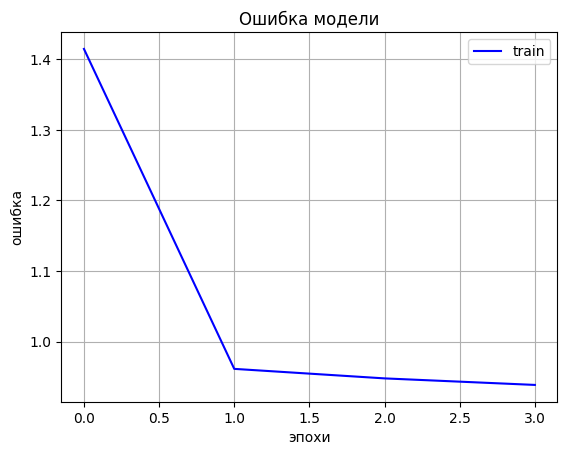

In [10]:
# Построим кривую лосса
from pylab import rcParams
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'b')
plt.title('Ошибка модели')
plt.ylabel('ошибка')
plt.xlabel('эпохи')
plt.legend(['train'], loc='best')
plt.grid(True)
plt.show()

In [11]:
# Получим эмбеддинги фильмов и пользователей из модели
movie_embeddings = movie_model.predict(UNIQUE_MOVIE_IDS)
user_embeddings = user_model.predict(np.unique(train.user_id))

30/30 [==============================] - 0s 901us/step


In [12]:
movie_embeddings.shape

(1682, 10)

In [13]:
# Эмбеддинги фильмов
movie_embeddings

array([[-0.03199071,  0.04669387,  0.00759717, ..., -0.03149531,
        -0.03004451, -0.02801979],
       [ 0.03109934,  0.04823415, -0.00541046, ...,  0.03803377,
         0.02241019,  0.01005242],
       [-0.00393618,  0.00848258, -0.02406535, ...,  0.04680772,
         0.04250915,  0.0166543 ],
       ...,
       [ 0.04773568, -0.03217337, -0.03600775, ...,  0.02299839,
        -0.00094951, -0.00632763],
       [ 0.03312165,  0.04777198, -0.00861215, ..., -0.01665266,
        -0.0426792 , -0.0442893 ],
       [ 0.04366206,  0.04474432, -0.03752955, ..., -0.01470007,
         0.00048848,  0.00995937]], dtype=float32)

In [14]:
user_embeddings.shape

(943, 10)

In [15]:
# Эмбеддинги пользователей
user_embeddings

array([[ 0.04211342,  0.0332008 ,  0.04123459, ...,  0.01160573,
         0.03339063,  0.03084215],
       [ 0.02469028, -0.03850884,  0.01664694, ...,  0.04506847,
        -0.03641459, -0.0042356 ],
       [-0.00665307, -0.03261993, -0.02441081, ...,  0.01628049,
         0.01745485, -0.02860355],
       ...,
       [-0.01021767,  0.02763755,  0.02823525, ...,  0.05181794,
        -0.04538717, -0.04769588],
       [-0.0231631 , -0.00796308,  0.03831246, ..., -0.00228257,
         0.05293152,  0.04446113],
       [ 0.01940224,  0.03424264, -0.00346672, ..., -0.03351131,
        -0.03890608,  0.00315541]], dtype=float32)

In [16]:
# Далее можно использовать KNN и рекомендовать пользователям фильмы